# Análisis de campañas de marketing (Portugal)

El análisis completo desde la **carga de datos**, **limpieza**, **análisis descriptivo**, **visualizaciones** y **conclusiones**.



In [28]:
# Librerías básicas
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Rutas de trabajo
BASE = Path('C:\\Users\\Carito\\Desktop\\MISCOSAS\\Python\\BaseDatos')
CSV_PATH = BASE / 'C:\\Users\\Carito\\Desktop\\MISCOSAS\\Python\\BaseDatos\\bank-additional.csv'
XLSX_PATH = BASE / 'C:\\Users\\Carito\\Desktop\\MISCOSAS\\Python\\BaseDatos\\customer-details.xlsx'


In [12]:
pip install openpyxl


Defaulting to user installation because normal site-packages is not writeable

   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   ---------------------------------------- 2/2 [openpyxl]

Note: you may need to restart the kernel to use updated packages.


## Carga de datos


In [ ]:
import csv
def read_csv_flexible(path):
    with open(path, 'r', encoding='utf-8', errors='ignore') as fh:
        sample = fh.read(8192)
    try:
        dialect = csv.Sniffer().sniff(sample, delimiters=[',',';','\t','|'])
        delim = dialect.delimiter
    except Exception:
        delim = ';'
    return pd.read_csv(path, delimiter=delim, encoding='utf-8', engine='python')

bank_raw = read_csv_flexible(CSV_PATH)
customers_raw = pd.concat([pd.read_excel(XLSX_PATH, sheet_name=s).assign(__source_sheet__=s) for s in pd.ExcelFile(XLSX_PATH).sheet_names], ignore_index=True)

print('bank rows:', len(bank_raw))
print('customers rows (concatenado):', len(customers_raw))

# Primeras filas para inspección
display(bank_raw.head())
display(customers_raw.head())

bank rows: 43000
customers rows (concatenado): 43170


,Unnamed: 0,age,job,marital,education,default,housing,loan,contact,duration,...,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,date,latitude,longitude,id_
0,0,NaN,housemaid,MARRIED,basic.4y,0.0,0.0,0.0,telephone,261,...,1.1,"93,994","-36,4","4,857",5191,no,2-agosto-2019,41.495,-71.233,089b39d8-e4d0-461b-87d4-814d71e0e079
1,1,57.0,services,MARRIED,high.school,NaN,0.0,0.0,telephone,149,...,1.1,"93,994","-36,4",NaN,5191,no,14-septiembre-2016,34.601,-83.923,e9d37224-cb6f-4942-98d7-46672963d097
2,2,37.0,services,MARRIED,high.school,0.0,1.0,0.0,telephone,226,...,1.1,"93,994","-36,4","4,857",5191,no,15-febrero-2019,34.939,-94.847,3f9f49b5-e410-4948-bf6e-f9244f04918b
3,3,40.0,admin.,MARRIED,basic.6y,0.0,0.0,0.0,telephone,151,...,1.1,"93,994","-36,4",NaN,5191,no,29-noviembre-2015,49.041,-70.308,9991fafb-4447-451a-8be2-b0df6098d13e
4,4,56.0,services,MARRIED,high.school,0.0,0.0,1.0,telephone,307,...,1.1,"93,994","-36,4",NaN,5191,no,29-enero-2017,38.033,-104.463,eca60b76-70b6-4077-80ba-bc52e8ebb0eb


,Unnamed: 0,Income,Kidhome,Teenhome,Dt_Customer,NumWebVisitsMonth,ID,__source_sheet__
0,0,161770,1,0,2012-04-04,29,089b39d8-e4d0-461b-87d4-814d71e0e079,2012
1,1,85477,1,1,2012-12-30,7,e9d37224-cb6f-4942-98d7-46672963d097,2012
2,2,147233,1,1,2012-02-02,5,3f9f49b5-e410-4948-bf6e-f9244f04918b,2012
3,3,121393,1,2,2012-12-21,29,9991fafb-4447-451a-8be2-b0df6098d13e,2012
4,4,63164,1,2,2012-06-20,20,eca60b76-70b6-4077-80ba-bc52e8ebb0eb,2012


## Limpieza y normalización de nombres de columnas
Se normalizan nombres (minúsculas, reemplazo de acentos y espacios).

In [14]:
def clean_columns(df):
    new_cols = []
    for c in df.columns:
        c2 = str(c).strip().lower()
        c2 = (c2.replace('á','a').replace('é','e').replace('í','i').replace('ó','o').replace('ú','u').replace('ñ','n'))
        for ch in [' ', '/', '-', '.', '(', ')', '[', ']', '{', '}', '%']:
            c2 = c2.replace(ch, '_')
        c2 = '_'.join([p for p in c2.split('_') if p!=''])
        new_cols.append(c2)
    df.columns = new_cols
    return df

bank = clean_columns(bank_raw.copy())
customers = clean_columns(customers_raw.copy())

# Eliminar columnas 'unnamed' generadas por índices
bank = bank.loc[:, ~bank.columns.str.startswith('unnamed')]
customers = customers.loc[:, ~customers.columns.str.startswith('unnamed')]

print('Columnas bank:', list(bank.columns))
print('Columnas customers:', list(customers.columns))

Columnas bank: ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y', 'date', 'latitude', 'longitude', 'id']
Columnas customers: ['income', 'kidhome', 'teenhome', 'dt_customer', 'numwebvisitsmonth', 'id', 'source_sheet']


## Conversión de tipos y normalizaciones
- Cast a numéricos
- Variables binarias a 0/1
- Parseo de fechas
- Generación de `contact_date` cuando sea posible

In [15]:
# Casts numéricos
numeric_cols_bank = ['age','duration','campaign','pdays','previous','emp_var_rate','cons_price_idx','cons_conf_idx','euribor3m','nr_employed']
for c in numeric_cols_bank:
    if c in bank.columns:
        bank[c] = pd.to_numeric(bank[c], errors='coerce')

numeric_cols_cust = ['income','kidhome','teenhome','numwebvisitsmonth','id']
for c in numeric_cols_cust:
    if c in customers.columns:
        customers[c] = pd.to_numeric(customers[c], errors='coerce')

# Booleanizar
def map_bool_series(s):
    s = s.astype(str).str.strip().str.lower()
    mapping = {'yes':1,'no':0,'1':1,'0':0,'si':1,'sí':1,'true':1,'false':0,'y':1,'n':0}
    return s.map(mapping)

for col in ['default','housing','loan']:
    if col in bank.columns:
        bank[col] = map_bool_series(bank[col]).astype('Int64')

if 'y' in bank.columns:
    bank['y'] = map_bool_series(bank['y']).astype('Int64')

# Fechas
bank['contact_date'] = pd.to_datetime(bank['date'], errors='coerce') if 'date' in bank.columns else pd.NaT
if 'dt_customer' in customers.columns:
    customers['dt_customer'] = pd.to_datetime(customers['dt_customer'], errors='coerce')

# Extraer mes si está
if 'contact_month' in bank.columns:
    bank['contact_month_clean'] = bank['contact_month'].astype(str).str.strip().str.lower().str[:3]
    month_map = {'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12,
                 'ene':1,'abr':4,'ago':8,'dic':12}
    bank['contact_month_num'] = bank['contact_month_clean'].map(month_map)

# Normalizar id a string para merge
if 'id_' in bank.columns and 'id' not in bank.columns:
    bank = bank.rename(columns={'id_':'id'})
if 'id' in bank.columns:
    bank['id'] = bank['id'].astype(str).str.strip()
if 'id' in customers.columns:
    customers['id'] = customers['id'].astype(str).str.strip()

display(bank[['id','contact_date']].head())
display(customers[['id','dt_customer']].head())

C:\Users\Carito\AppData\Local\Temp\ipykernel_15216\1467059774.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  bank['contact_date'] = pd.to_datetime(bank['date'], errors='coerce') if 'date' in bank.columns else pd.NaT


,id,contact_date
0,089b39d8-e4d0-461b-87d4-814d71e0e079,NaT
1,e9d37224-cb6f-4942-98d7-46672963d097,NaT
2,3f9f49b5-e410-4948-bf6e-f9244f04918b,NaT
3,9991fafb-4447-451a-8be2-b0df6098d13e,NaT
4,eca60b76-70b6-4077-80ba-bc52e8ebb0eb,NaT


,id,dt_customer
0,nan,2012-04-04
1,nan,2012-12-30
2,nan,2012-02-02
3,nan,2012-12-21
4,nan,2012-06-20


## Eliminación de duplicados y unión por `id`
Se mantiene la última interacción por cliente según `contact_date` cuando esté disponible.

In [17]:
# Eliminar duplicados en bank conservando la última interacción por fecha si existe
if 'id' in bank.columns:
    if 'contact_date' in bank.columns:
        bank = bank.sort_values('contact_date').drop_duplicates(subset=['id'], keep='last')
    else:
        bank = bank.drop_duplicates(subset=['id'], keep='last')
else:
    bank = bank.drop_duplicates()

if 'id' in customers.columns:
    customers = customers.drop_duplicates(subset=['id'], keep='last')
else:
    customers = customers.drop_duplicates()

# Merge
if 'id' in bank.columns and 'id' in customers.columns:
    merged = bank.merge(customers, how='left', on='id', suffixes=('','_cust'))
else:
    merged = bank.copy()

print('Bank limpio:', len(bank))
print('Customers limpios:', len(customers))
print('Merged rows:', len(merged))
display(merged.head())

Bank limpio: 43000
Customers limpios: 1
Merged rows: 43000


,age,job,marital,education,default,housing,loan,contact,duration,campaign,...,latitude,longitude,id,contact_date,income,kidhome,teenhome,dt_customer,numwebvisitsmonth,source_sheet
0,NaN,housemaid,MARRIED,basic.4y,<NA>,<NA>,<NA>,telephone,261,1,...,41.495,-71.233,089b39d8-e4d0-461b-87d4-814d71e0e079,NaT,NaN,NaN,NaN,NaT,NaN,NaN
1,57.0,services,MARRIED,high.school,<NA>,<NA>,<NA>,telephone,149,1,...,34.601,-83.923,e9d37224-cb6f-4942-98d7-46672963d097,NaT,NaN,NaN,NaN,NaT,NaN,NaN
2,37.0,services,MARRIED,high.school,<NA>,<NA>,<NA>,telephone,226,1,...,34.939,-94.847,3f9f49b5-e410-4948-bf6e-f9244f04918b,NaT,NaN,NaN,NaN,NaT,NaN,NaN
3,40.0,admin.,MARRIED,basic.6y,<NA>,<NA>,<NA>,telephone,151,1,...,49.041,-70.308,9991fafb-4447-451a-8be2-b0df6098d13e,NaT,NaN,NaN,NaN,NaT,NaN,NaN
4,56.0,services,MARRIED,high.school,<NA>,<NA>,<NA>,telephone,307,1,...,38.033,-104.463,eca60b76-70b6-4077-80ba-bc52e8ebb0eb,NaT,NaN,NaN,NaN,NaT,NaN,NaN


## Variables derivadas
- Bines para `duration` e `income`
- Tiempo como cliente (meses) si es posible

In [21]:
import numpy as np
import pandas as pd

# Bines de duración en bank
if 'duration' in bank.columns and bank['duration'].notna().sum() > 0:
    try:
        dur_q = np.unique(np.quantile(bank['duration'].dropna(), np.linspace(0, 1, 11)))
        bank['_duration_bin'] = pd.cut(bank['duration'], bins=dur_q, include_lowest=True)
    except Exception:
        bank['_duration_bin'] = pd.cut(bank['duration'].fillna(0), bins=5)
else:
    bank['_duration_bin'] = pd.Series([np.nan]*len(bank))  # crea columna vacía si no existe duration

# Bines de income en merged
if 'income' in merged.columns:
    if merged['income'].notna().sum() > 0:
        try:
            inc_q = np.unique(np.quantile(merged['income'].dropna(), np.linspace(0, 1, 11)))
            merged['_income_bin'] = pd.cut(merged['income'], bins=inc_q, include_lowest=True)
        except Exception:
            merged['_income_bin'] = pd.cut(merged['income'].fillna(0), bins=5)
    else:
        merged['_income_bin'] = pd.cut(merged['income'].fillna(0), bins=5)
else:
    merged['_income_bin'] = pd.Series([np.nan]*len(merged))  # crea columna vacía si no existe income

# Meses como cliente
if 'dt_customer' in merged.columns and 'contact_date' in merged.columns:
    merged['months_as_customer'] = ((merged['contact_date'] - merged['dt_customer']).dt.days / 30).round(1)
else:
    merged['months_as_customer'] = pd.Series([np.nan]*len(merged))  # columna vacía si faltan fechas

# Mostrar resultados
display(bank['_duration_bin'].head())
display(merged['_income_bin'].head())
display(merged['months_as_customer'].head())


0    (221.0, 279.0]
1    (146.0, 179.0]
2    (221.0, 279.0]
3    (146.0, 179.0]
4    (279.0, 367.0]
Name: _duration_bin, dtype: category
Categories (10, interval[float64, right]): [(-0.001, 59.0] < (59.0, 89.0] < (89.0, 116.0] < (116.0, 146.0] ... (221.0, 279.0] < (279.0, 367.0] < (367.0, 549.0] < (549.0, 4918.0]]

0    (-0.0002, 0.0002]
1    (-0.0002, 0.0002]
2    (-0.0002, 0.0002]
3    (-0.0002, 0.0002]
4    (-0.0002, 0.0002]
Name: _income_bin, dtype: category
Categories (5, interval[float64, right]): [(-0.001, -0.0006] < (-0.0006, -0.0002] < (-0.0002, 0.0002] < (0.0002, 0.0006] < (0.0006, 0.001]]

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: months_as_customer, dtype: float64

## Análisis descriptivo
- Tasa global
- Por ocupación, marital, education, month
- Efecto del nº de contactos y duración
- Efecto de `poutcome`

In [ ]:
analysis = {}
analysis['n_bank'] = len(bank)
analysis['n_customers'] = len(customers)
analysis['n_merged'] = len(merged)
analysis['subscription_rate'] = float(bank['y'].dropna().mean()) if 'y' in bank.columns else np.nan
analysis

# Tasa por ocupación
if 'job' in bank.columns and 'y' in bank.columns:
    by_job = bank.groupby('job', dropna=False)['y'].agg(['count','mean']).reset_index().rename(columns={'mean':'subscription_rate'}).sort_values('subscription_rate', ascending=False)
else:
    by_job = pd.DataFrame()

# Por marital y educacion
by_marital = bank.groupby('marital', dropna=False)['y'].agg(['count','mean']).reset_index().rename(columns={'mean':'subscription_rate'}) if 'marital' in bank.columns else pd.DataFrame()
by_education = bank.groupby('education', dropna=False)['y'].agg(['count','mean']).reset_index().rename(columns={'mean':'subscription_rate'}) if 'education' in bank.columns else pd.DataFrame()

# Por mes de contacto
by_month = bank.groupby('contact_month', dropna=False)['y'].agg(['count','mean']).reset_index().rename(columns={'mean':'subscription_rate'}) if 'contact_month' in bank.columns else pd.DataFrame()

# Campaign and duration curves
campaign_curve = bank.groupby('campaign')['y'].mean().reset_index().rename(columns={'y':'subscription_rate'}) if 'campaign' in bank.columns else pd.DataFrame()
duration_curve = bank.groupby('_duration_bin')['y'].mean().reset_index().rename(columns={'y':'subscription_rate'}) if '_duration_bin' in bank.columns else pd.DataFrame()
poutcome_rates = bank.groupby('poutcome', dropna=False)['y'].agg(['count','mean']).reset_index().rename(columns={'mean':'subscription_rate'}) if 'poutcome' in bank.columns else pd.DataFrame()

# Income curve
income_curve = merged.groupby('_income_bin')['y'].mean().reset_index().rename(columns={'y':'subscription_rate'}) if '_income_bin' in merged.columns and 'y' in merged.columns else pd.DataFrame()

print('Tasa global de suscripción (y=1): {:.2%}'.format(analysis['subscription_rate'] if not np.isnan(analysis['subscription_rate']) else 0))
display(by_job.head(10))
display(by_marital)
display(by_education)
display(by_month.head(12))

Tasa global de suscripción (y=1): 11.27%


C:\Users\Carito\AppData\Local\Temp\ipykernel_15216\1488341192.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  duration_curve = bank.groupby('_duration_bin')['y'].mean().reset_index().rename(columns={'y':'subscription_rate'}) if '_duration_bin' in bank.columns else pd.DataFrame()
C:\Users\Carito\AppData\Local\Temp\ipykernel_15216\1488341192.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_curve = merged.groupby('_income_bin')['y'].mean().reset_index().rename(columns={'y':'subscription_rate'}) if '_income_bin' in merged.columns and 'y' in merged.columns else pd.DataFrame()


,job,count,subscription_rate
8,student,903,0.3134
5,retired,1790,0.251955
10,unemployed,1063,0.143932
0,admin.,10873,0.130139
11,NaN,345,0.113043
4,management,3050,0.112131
9,technician,7026,0.108454
6,self-employed,1489,0.108126
3,housemaid,1123,0.098842
2,entrepreneur,1522,0.082786


,marital,count,subscription_rate
0,DIVORCED,4811,0.10185
1,MARRIED,25999,0.102119
2,SINGLE,12105,0.139281
3,NaN,85,0.152941


,education,count,subscription_rate
0,basic.4y,4356,0.102847
1,basic.6y,2386,0.081308
2,basic.9y,6309,0.078142
3,high.school,9925,0.108413
4,illiterate,18,0.222222
5,professional.course,5477,0.113201
6,university.degree,12722,0.1374
7,NaN,1807,0.144438


""


## Visualizaciones
Se genero gráficos con matplotlib (in-line) y se guardaron en `./plots/`.

In [27]:
!pip install matplotlib
import matplotlib.pyplot as plt



Defaulting to user installation because normal site-packages is not writeable


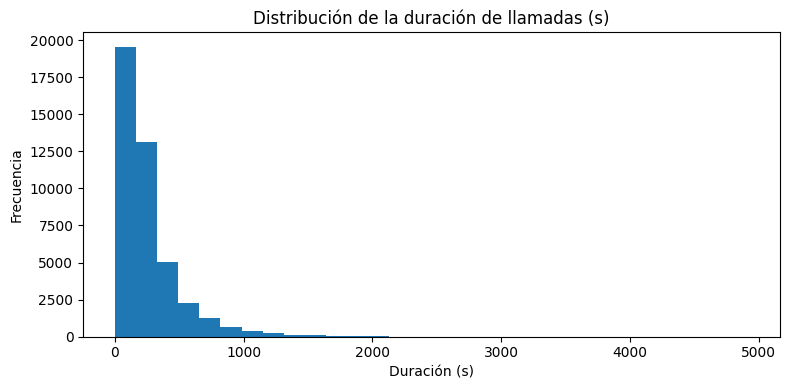

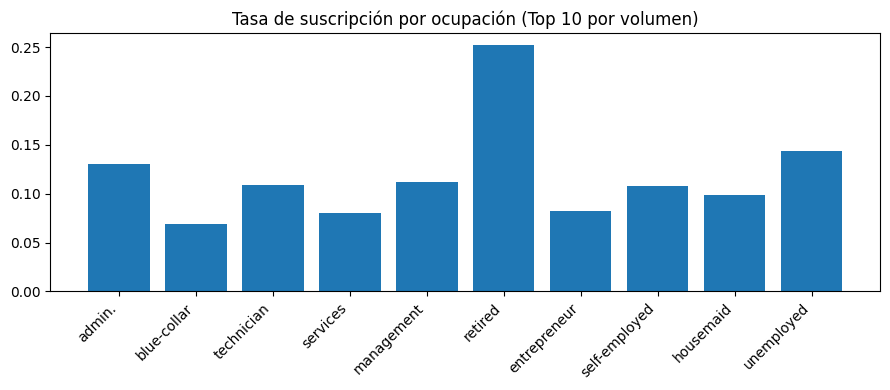

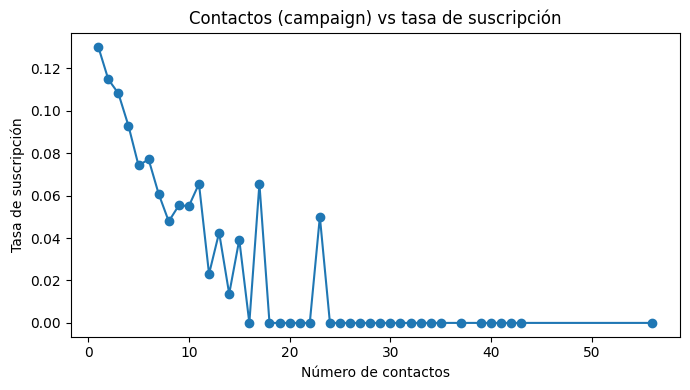

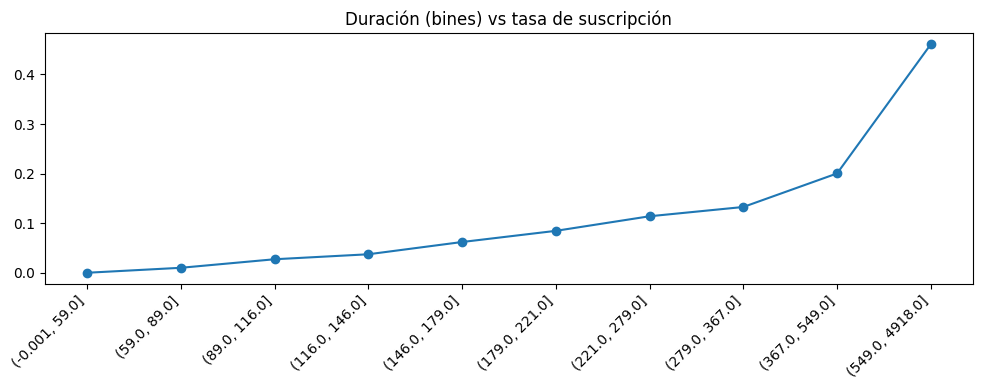

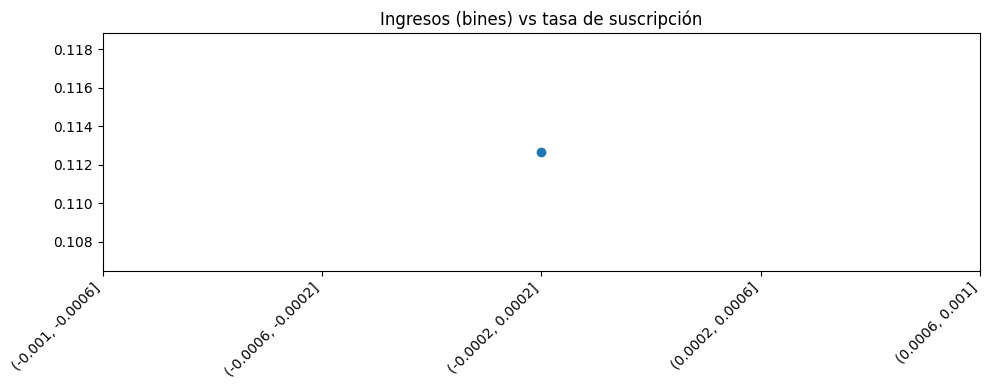

Gráficos guardados en: C:\Users\Carito\Desktop\MISCOSAS\Python\BaseDatos\plots


In [ ]:
# Carpeta plots
plots_dir = BASE / 'plots'
plots_dir.mkdir(exist_ok=True)

# 1. Histograma de duración
if 'duration' in bank.columns and bank['duration'].notna().sum()>0:
    plt.figure(figsize=(8,4))
    plt.hist(bank['duration'].dropna(), bins=30)
    plt.title('Distribución de la duración de llamadas (s)')
    plt.xlabel('Duración (s)')
    plt.ylabel('Frecuencia')
    plt.tight_layout()
    plt.savefig(plots_dir / 'plot_duration_hist.png')
    display(plt.gcf())
    plt.close()

# 2. Tasa por ocupación (Top 10 por volumen)
if not by_job.empty:
    top_jobs = by_job.sort_values('count', ascending=False).head(10)
    plt.figure(figsize=(9,4))
    plt.bar(top_jobs['job'].astype(str), top_jobs['subscription_rate'])
    plt.title('Tasa de suscripción por ocupación (Top 10 por volumen)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(plots_dir / 'plot_rate_by_job.png')
    display(plt.gcf())
    plt.close()

# 3. Campana vs rate
if not campaign_curve.empty:
    plt.figure(figsize=(7,4))
    plt.plot(campaign_curve['campaign'], campaign_curve['subscription_rate'], marker='o')
    plt.title('Contactos (campaign) vs tasa de suscripción')
    plt.xlabel('Número de contactos')
    plt.ylabel('Tasa de suscripción')
    plt.tight_layout()
    plt.savefig(plots_dir / 'plot_campaign_vs_rate.png')
    display(plt.gcf())
    plt.close()

# 4. Duración bines vs tasa
if not duration_curve.empty:
    labels = duration_curve['_duration_bin'].astype(str)
    plt.figure(figsize=(10,4))
    plt.plot(range(len(labels)), duration_curve['subscription_rate'], marker='o')
    plt.title('Duración (bines) vs tasa de suscripción')
    plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(plots_dir / 'plot_duration_vs_rate.png')
    display(plt.gcf())
    plt.close()

# 5. Income bines vs tasa
if not income_curve.empty:
    labels = income_curve['_income_bin'].astype(str)
    plt.figure(figsize=(10,4))
    plt.plot(range(len(labels)), income_curve['subscription_rate'], marker='o')
    plt.title('Ingresos (bines) vs tasa de suscripción')
    plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(plots_dir / 'plot_income_vs_rate.png')
    display(plt.gcf())
    plt.close()

print('Gráficos guardados en:', plots_dir)

## Archivos limpios para ser entregados
Se guardan `clean_bank.csv`, `clean_customers.csv`, `merged_bank_customers.csv` 

In [30]:
# Guardar CSVs limpios y merged
clean_bank_path = BASE / 'clean_bank.csv'
clean_customers_path = BASE / 'clean_customers.csv'
merged_path = BASE / 'merged_bank_customers.csv'

bank.to_csv(clean_bank_path, index=False)
customers.to_csv(clean_customers_path, index=False)
merged.to_csv(merged_path, index=False)

# Guardar informe breve en Markdown
report_md = BASE / 'proyecto_informe_entrega.md'
with open(report_md, 'w', encoding='utf-8') as fh:
    fh.write('# Informe breve - Proyecto de Marketing\n\n')
    fh.write(f'Registros bank (limpio): {len(bank)}\n')
    fh.write(f'Registros customers (limpio): {len(customers)}\n')
    fh.write(f'Registros merged: {len(merged)}\n')
    fh.write(f'Tasa global de suscripción: {analysis.get("subscription_rate"):.2%}\n')

print('Archivos guardados:')
print(clean_bank_path)
print(clean_customers_path)
print(merged_path)
print(report_md)

Archivos guardados:
C:\Users\Carito\Desktop\MISCOSAS\Python\BaseDatos\clean_bank.csv
C:\Users\Carito\Desktop\MISCOSAS\Python\BaseDatos\clean_customers.csv
C:\Users\Carito\Desktop\MISCOSAS\Python\BaseDatos\merged_bank_customers.csv
C:\Users\Carito\Desktop\MISCOSAS\Python\BaseDatos\proyecto_informe_entrega.md
